# PCA and LDA

This exercise tries to show the basics on how to use PCA and LDA to perform unsupervised (PCA) and supervised (LDA) dimensionality reduction, in order to obtain better classification results.

The exercise is based on the [Wine dataset](https://archive.ics.uci.edu/ml/datasets/wine), which is a multinomial classification problem with 13 numerical features and 178 samples.

In [1]:
%run hide_code_in_slideshow.py

In [2]:
# Imports
import warnings

warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
from dataset import Dataset
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns; sns.set()
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from matplotlib import pyplot

Read the Wine dataset

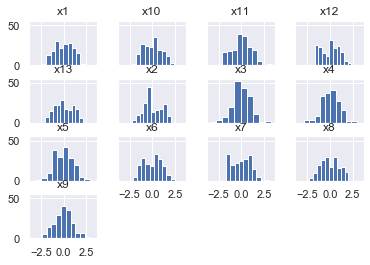

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
wine = Dataset(url, header=None, delimiter=',')
wine.set_target('x0').scale().fix_skewness()

# Plot the histograms of the features
wine.features.hist(sharex=True, sharey=True)
plt.show();

## PCA

Applying PCA to the dataset is extremely simple. Let's do it specifying the number of components, and print out the explained variance from each of the components, by accessing the internal property of `pca` called `explained_variance_ratio_` which is an array of `n_components`.

In [4]:
pca = PCA(n_components=3)
X = pca.fit(wine.features).transform(wine.features)
y = wine.target

In [5]:
# Percentage of variance explained for each components
explained_variance = pca.explained_variance_ratio_
num_components = len(explained_variance)
print('Explained variance (first {} components): {}'.format(
    len(explained_variance), str(explained_variance)))

Explained variance (first 3 components): [0.35141598 0.20861857 0.11324707]


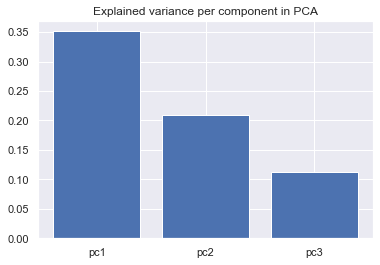

In [6]:
hide_code_in_slideshow()
plt.bar(range(num_components), explained_variance)
plt.xticks(range(num_components), ('pc1', 'pc2', 'pc3'))
plt.title('Explained variance per component in PCA')
plt.show();

Now, the interpretation. We will make three plots

  1. PC1 vs. PC2
  2. PC1 vs. PC3
  3. PC2 vs. PC3
  
to see which one helps me more in separating the three different classes in the dataset.

In [7]:
def plot_pc(pc_i, pc_j):
    target_names = list(wine.target.unique())
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    for color, i in zip(colors, target_names):
        plt.scatter(X[wine.target == i, pc_i], X[wine.target == i, pc_j], 
                    color=color, alpha=.8, lw=lw,
                    label=i)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of Wine dataset')
    plt.xlabel('PC{}'.format(pc_i+1)); plt.ylabel('PC{}'.format(pc_j+1))

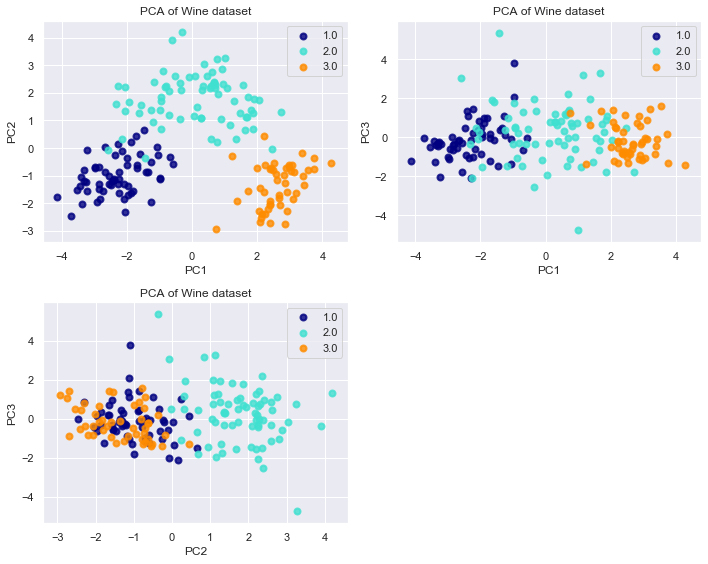

In [8]:
hide_code_in_slideshow()
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plot_pc(0, 1)
plt.subplot(2,2,2)
plot_pc(0, 2)
plt.subplot(2,2,3)
plot_pc(1, 2)
plt.tight_layout()
plt.show();

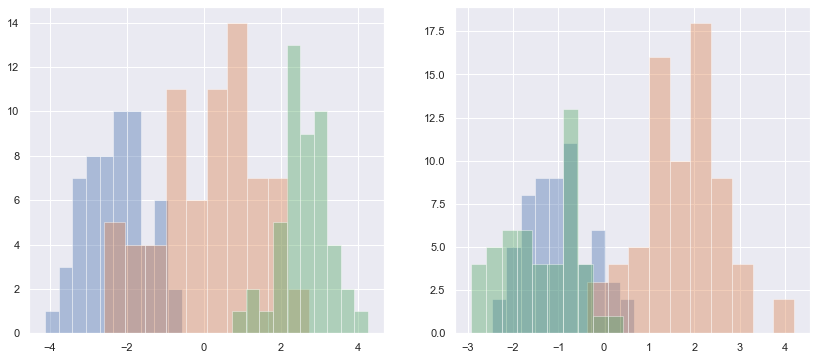

In [9]:
ndf = pd.concat((pd.DataFrame(X), y), axis=1)
ndf.columns = ['PC1','PC2','PC3','label']

fig, axs = plt.subplots(ncols=2)
fig.set_figheight(6)
fig.set_figwidth(14)
ndf.groupby("label").PC1.hist(alpha=0.4, ax=axs[0]);
ndf.groupby("label").PC2.hist(alpha=0.4, ax=axs[1]);

## LDA

In [10]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit(wine.features, wine.target).transform(wine.features)

X_lda.shape

(178, 2)

Let's take a look to the scaling vectors produced by the LDA. These are the ones you should use to re-scale all your input in order to be translated to a new set of axis where the ratio between-classes by within-classes is maximized. They're inside the `lda` object as a property called `scalings_`.

In [11]:
def printArray(arr):
    for row in arr:
        for item in row:
            print("{:6.1f}".format(item), end = " ")
        print("")

printArray(lda.scalings_)

  -0.3    0.7 
   0.2    0.4 
  -0.1    0.5 
   0.5   -0.5 
  -0.0   -0.0 
   0.4   -0.0 
  -1.9   -0.4 
  -0.2   -0.2 
   0.1   -0.2 
   1.1    0.8 
  -0.2   -0.2 
  -0.6    0.2 
  -0.8    0.9 


We can only represent the first two linear discrinant vectors (aka: scaling vectors). We see how weel a 13-dimensional problem can now be easily plotted and solved.

In [12]:
def plot_ld(ld_i, ld_j):
    target_names = list(wine.target.unique())
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    for color, i in zip(colors, target_names):
        plt.scatter(X_lda[wine.target == i, ld_i], X_lda[wine.target == i, ld_j], 
                    color=color, alpha=.8, lw=lw,
                    label=i)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('LDA of Wine dataset')
    plt.xlabel('LD{}'.format(ld_i+1)); plt.ylabel('LD{}'.format(ld_j+1))

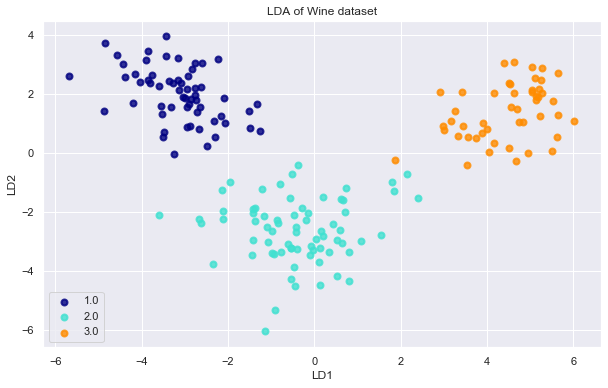

In [13]:
hide_code_in_slideshow()
plt.figure(figsize=(10,6))
plot_ld(0, 1)
plt.show();

### Predicting with LDA.

In [14]:
# Split the dataset.
X, y = wine.split()
lda = LinearDiscriminantAnalysis().fit(X.train, y.train)

# Evaluate using cross-validation, what is the performance in training.
accuracies = cross_val_score(lda, X=X.train, y=y.train, scoring='accuracy')
print('Avg. Acc (training): {:.2f} +/- {:.2f}'.format(
    np.mean(accuracies), np.std(accuracies)))

# Finally, evaluate my model in test.
test_score = accuracy_score(y.test, lda.predict(X.test))
print('Acc (test): {:.2f}'.format(test_score))

Avg. Acc (training): 0.99 +/- 0.02
Acc (test): 0.94


# Factor Analysis

As you can imagine, factor analysis can lead to controversy if you’re trying to measure quantities such as “intelligence”, “compassion”, “potential” and so forth. Are those quantities that can be measured? Are they responsible for events that we can measure, such as high SAT scores or hours volunteered for community service? The voluminous statistical output of factor analysis does not answer that for you. You need to make those hard decisions. However we can use factor analysis to explore our data and better understand the covariance between our variables.

More [here](https://data.library.virginia.edu/getting-started-with-factor-analysis/)

In [15]:
X, y = wine.features, wine.target
factor = FactorAnalysis(n_components=len(list(wine.features)), 
                        random_state=101).fit(X)

At the intersection of each factor and feature, a positive number indicates that a positive proportion exists between the two; a negative number, instead, points out that they diverge and one is the contrary to the other.

In [16]:
factors = pd.DataFrame(factor.components_, columns=wine.names('features')).T
factors

,0,1,2,3,4,5,6,7,8,9,10,11,12
x1,-0.318438,-0.689186,-0.141432,0.003511,-0.099282,-0.036469,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0
x2,0.416632,-0.360033,0.232937,0.241380,0.010923,-0.090288,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0
x3,-0.050412,-0.381525,0.582677,-0.191556,-0.004928,-0.015426,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
x4,0.461036,0.073923,0.580783,-0.015236,0.024081,0.017978,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
x5,-0.278998,-0.454571,0.087247,-0.164825,0.272954,0.009355,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x6,-0.847621,-0.039578,0.122078,0.062662,-0.054633,0.022109,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0
x7,-0.893295,0.045547,0.113617,0.045735,-0.030743,0.009170,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
x8,0.574189,-0.043823,0.173044,-0.146178,-0.241212,0.015531,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
x9,-0.665411,0.012538,0.150161,0.170019,0.015590,0.070860,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0
x10,0.085823,-0.796419,-0.053074,0.063033,-0.043944,0.051125,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0


Factor Analysis are probabilistic models. The consequence is that the likelihood of new data can be used for model selection and covariance estimation. Here we plot FA score with cross-validation on the original dataset.-

In [17]:
fa = FactorAnalysis()

fa_scores = []
for n in range(len(list(wine.features))):
    fa.n_components = n
    fa_scores.append(np.mean(cross_val_score(fa, X, cv=5)))

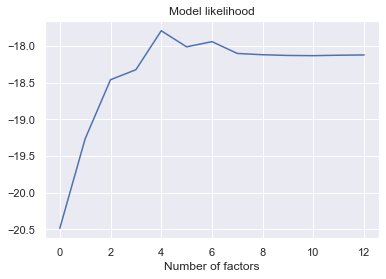

In [18]:
hide_code_in_slideshow()
plt.plot(range(len(list(wine.features))), fa_scores)
plt.title('Model likelihood')
plt.xlabel('Number of factors')
plt.show();

Another version with FactorAnalyzer package.

In [35]:
fa = FactorAnalyzer(rotation='varimax')

fa.fit(wine.features)
fa.loadings_

array([[ 6.89352335e-02,  7.90735951e-01, -5.55431486e-02],
       [-4.54054886e-01,  1.73703746e-01,  3.06273406e-01],
       [ 5.71859980e-02,  3.09806255e-01,  7.46195062e-01],
       [-2.98712873e-01, -3.21506149e-01,  7.40487599e-01],
       [ 1.62889792e-01,  4.84309528e-01,  1.40583795e-01],
       [ 8.23666978e-01,  2.90291624e-01,  1.32975145e-02],
       [ 9.31358548e-01,  2.25638175e-01, -7.51974982e-04],
       [-5.10179390e-01, -1.61383134e-01,  2.44776601e-01],
       [ 6.33026589e-01,  1.72292875e-01,  2.49462080e-02],
       [-3.48302214e-01,  7.92864556e-01,  1.06336744e-01],
       [ 6.46161541e-01, -1.91574419e-01, -1.72846377e-01],
       [ 8.32089762e-01, -1.00586075e-02, -3.99538160e-02],
       [ 3.19395861e-01,  7.39034481e-01, -8.75886243e-02]])

In [34]:
fa.loadings_[:, 0:1]

array([[ 0.06893523],
       [-0.45405489],
       [ 0.057186  ],
       [-0.29871287],
       [ 0.16288979],
       [ 0.82366698],
       [ 0.93135855],
       [-0.51017939],
       [ 0.63302659],
       [-0.34830221],
       [ 0.64616154],
       [ 0.83208976],
       [ 0.31939586]])

A way to procced from here is to consider variables with similar (high = close to 1) value for the same loading as representing the same "latent" concept. For example, variables $x6$, $x7$, $x9$ and $x12$ present a high value for the first factor, which could be interpreted as an opportunity to represent them as an unique variable in the projected space. Another example could be $x1$, $x13$ and maybe $x10$ too, for the 2nd factor, but no more than that.

We could even try to represent these correspondence in a plot to see which features align in those regions with higher value for the loadings of the factors

AttributeError: 'numpy.ndarray' object has no attribute 'index'

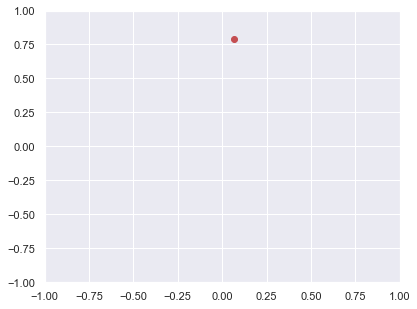

In [40]:
# Plot the loadings
import matplotlib.transforms as mtransforms

fig = plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 2, 1)

# If we want the same offset for each text instance,
# we only need to make one transform.  To get the
# transform argument to offset_copy, we need to make the axes
# first; the subplot command above is one way to do this.
trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=0.05, y=0.10, units='inches')

plt.xlim(-1, +1); plt.ylim(-1, +1)
for i, (x, y) in enumerate(zip(fa.loadings_[:, 0:1], fa.loadings_[:, 1:2])):
    plt.plot(x, y, 'ro')
    plt.text(x, y, fa.loadings_.index.tolist()[i], transform=trans_offset)
plt.axhline(c='k', linewidth=1); plt.axvline(c='k', linewidth=1)
plt.xlabel('Factor1'); plt.ylabel('Factor2')
plt.title('Factor Loadings for 1st and 2nd factors')

ax = plt.subplot(1, 2, 2)
trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=0.05, y=0.10, units='inches')

plt.xlim(-1, +1); plt.ylim(-1, +1)
for i, (x, y) in enumerate(zip(fa.loadings_[:, 2:3], fa.loadings_[:, 3:4])):
    plt.plot(x, y, 'ro')
    plt.text(x, y, fa.loadings.index.tolist()[i], transform=trans_offset)
plt.axhline(c='k', linewidth=1); plt.axvline(c='k', linewidth=1)
plt.xlabel('Factor3'); plt.ylabel('Factor4')
plt.title('Factor Loadings for 3rd and 4th factors')

plt.show();

### Uniqueness. 

The way to obtain it is, by calling `fa.get_uniqueness()`.

What we’re looking for are high numbers. A high uniqueness for a variable usually means it doesn’t fit neatly into our factors. It seems that $x2$ and $x5$ are the only ones that could not fit into our new factors.

In [ ]:
fa.get_uniqueness().plot.bar()
plt.show();

It seems that the only feature with a real high value for _uniqueness_ is $x5$, so we should not include it in our dimensionality reduction exercise, if we find a way to express similar variables through new _latent_ ones.

Let's transform the input dataset through the factors and plot the first two new dimensions to see if it helps to conduct a better classification exercise.

In [ ]:
hide_code_in_slideshow()
X, y = wine.features, wine.target
factor = FactorAnalysis(n_components=4, random_state=101).fit(X)
X_factor = factor.transform(X)

def plot_factor(factor_i, factor_j):
    target_names = list(wine.target.unique())
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    for color, i in zip(colors, target_names):
        plt.scatter(X_factor[wine.target == i, factor_i], 
                    X_factor[wine.target == i, factor_j], 
                    color=color, alpha=.8, lw=lw,
                    label=i)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('FA of Wine dataset')
    plt.xlabel('FA{}'.format(factor_i+1)); plt.ylabel('FA{}'.format(factor_j+1))

plt.figure(figsize=(10,6))
plot_factor(0, 1)
plt.show();